# IMC05 — The Sieve of Eratosthenes: Parallel Prime Detection

| | |
|---|---|
| **Course** | CISC 719 — Contemporary Computing Systems Modeling Algorithms (CCSM) |
| **University** | Harrisburg University of Science and Technology |
| **Student** | Kenneth Peter Fernandes |
| **Program** | Ph.D. in Computational Sciences |
| **Instructor** | Professor Majid Shaalan, Ph.D. |
| **Semester** | Spring 2026 |

---

## Assignment Scope

This notebook implements and benchmarks the Sieve of Eratosthenes using a **serial baseline**, **OpenMP** (shared-memory CPU), and **CUDA/Numba GPU** in Google Colab. The assignment requirement of at least two parallel implementations is satisfied by **OpenMP** and **CUDA/Numba GPU**.

**Implementations covered:**
- Serial Baseline (C++, segmented, odd-only, bit-packed)
- OpenMP (C++, shared memory, parallel segmented sieve)
- CUDA/Numba GPU (Python, second required parallel model)

**Bit-packing and segmentation are used for N ≥ 10⁹ as required by the assignment.**

---
## 1. Environment Setup (Google Colab)

Detect GPU, CPU, and compiler versions to confirm the runtime environment and support reproducibility.

In [16]:
# GPU detection
!nvidia-smi || true

# CPU info
!lscpu | head -40

# Compiler versions
!gcc --version
!g++ --version

Tue Feb 24 03:48:47 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P0             27W /   70W |     537MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
import sys, platform
print("Python:", sys.version)
print("Platform:", platform.platform())

# Verify / install Numba for GPU section
!pip install numba -q
import numba
print("Numba:", numba.__version__)

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.113+-x86_64-with-glibc2.35
Numba: 0.60.0


---
## 2. Problem Overview + PCAM Plan

### The Sieve of Eratosthenes

The Sieve of Eratosthenes finds all primes up to N by iteratively marking multiples of each prime p ≤ √N as composite.
- **Time complexity:** O(N log log N)
- **Space complexity (naïve):** O(N) bytes

**Why segmentation?** For large N (≥ 10⁸), the full sieve array may not fit in CPU cache, causing cache thrashing. Segmentation divides [2, N] into cache-sized chunks processed one at a time.

**Why bit-packing?** Storing each number as 1 bit instead of 1 byte reduces memory by 8×. For N = 10⁹: ~1 GB → ~125 MB.

---

### PCAM Summary Table

| Implementation | Partitioning | Communication | Agglomeration | Mapping |
|:---|:---|:---|:---|:---|
| **Serial** | N/A — single partition | N/A | Full range, one core | One CPU core |
| **OpenMP** | Range [2,N] split into equal chunks per thread | Read-only shared access to base primes (√N); no write conflicts | Chunks sized to L2/L3 cache; `schedule(dynamic)` | `#pragma omp parallel for` → available CPU cores |
| **Numba GPU** | Each CUDA thread handles one element in the sieve | No inter-thread communication required | Threads in warps/blocks tuned for GPU occupancy | CUDA thread blocks → GPU Streaming Multiprocessors |

> This table will be expanded with implementation-specific details in the report.

---
## 3. Benchmarking Protocol

Defines how performance is measured before any implementation runs. All timing decisions are made here.

**Metrics collected:**
- Wall-clock runtime (seconds)
- Speedup: S_p = T_serial / T_p
- Efficiency: E_p = S_p / p
- Correctness: prime count vs known values

**Scaling plans:**
- **Strong scaling** — fix N, vary thread count (OpenMP)
- **Weak scaling** — scale N proportionally with thread count

**Memory estimation:** M(N) = N/8 bytes (bit-packed, odd-only ≈ N/16 bytes)

In [18]:
# ── Benchmarking Configuration ──────────────────────────────────────────────

N_VALUES       = [10**6, 10**7, 5*10**7, 10**8]   # problem sizes
TRIALS         = 3                                  # runs per config (median reported)
THREAD_COUNTS  = [1, 2, 4]                          # OpenMP thread counts (Colab ~2 cores)
SEG_SIZE_BITS  = 1 << 19                            # segment size in bits (~64 KB)
BIT_PACKED     = True                               # use bit-packing for large N

# Weak scaling: N scales with thread count
WEAK_BASE_N    = 10**7                              # base N for 1 thread
WEAK_N_VALUES  = {t: WEAK_BASE_N * t for t in THREAD_COUNTS}

print("N values:", N_VALUES)
print("Thread counts:", THREAD_COUNTS)
print("Weak scaling N:", WEAK_N_VALUES)
print("Estimated memory (bit-packed, N=1e8):", 10**8 // 8 // 1024 // 1024, "MB")

N values: [1000000, 10000000, 50000000, 100000000]
Thread counts: [1, 2, 4]
Weak scaling N: {1: 10000000, 2: 20000000, 4: 40000000}
Estimated memory (bit-packed, N=1e8): 11 MB


---
## 4. Shared Utilities

Helper functions for running shell commands, parsing output, recording results, and computing speedup/efficiency.

In [19]:
import subprocess, re, time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


def run_cmd(cmd: str) -> str:
    """Run a shell command and return stdout as string."""
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("[STDERR]", result.stderr.strip())
    return result.stdout.strip()


def parse_serial_output(output: str) -> dict:
    """
    Parse output of format: N=<n> count=<count> time_sec=<time>
    Returns dict with keys: N, count, time_sec
    """
    pattern = r"N=(\d+)\s+count=(\d+)\s+time_sec=([\d.]+)"
    m = re.search(pattern, output)
    if not m:
        raise ValueError(f"Could not parse output: {output!r}")
    return {"N": int(m[1]), "count": int(m[2]), "time_sec": float(m[3])}


def parse_openmp_output(output: str) -> dict:
    """
    Parse output of format: N=<n> threads=<t> count=<count> time_sec=<time>
    """
    pattern = r"N=(\d+)\s+threads=(\d+)\s+count=(\d+)\s+time_sec=([\d.]+)"
    m = re.search(pattern, output)
    if not m:
        raise ValueError(f"Could not parse output: {output!r}")
    return {"N": int(m[1]), "threads": int(m[2]), "count": int(m[3]), "time_sec": float(m[4])}


def record_result(results: list, impl: str, N: int, workers: int,
                  trial: int, runtime: float, count: int, **kwargs):
    """Append one result row to the results list."""
    results.append({
        "implementation": impl,
        "platform":        "Google Colab",
        "N":               N,
        "workers":         workers,
        "trial":           trial,
        "runtime_sec":     runtime,
        "prime_count":     count,
        "segment_size":    SEG_SIZE_BITS,
        "bit_packed":      BIT_PACKED,
        **kwargs
    })


def compute_speedup_efficiency(df: pd.DataFrame,
                               baseline_impl: str = "serial") -> pd.DataFrame:
    """
    Add speedup and efficiency columns relative to the serial baseline.
    Groups by N and uses median runtime across trials.
    """
    median_df = df.groupby(["implementation", "N", "workers"])["runtime_sec"].median().reset_index()
    baseline  = median_df[median_df["implementation"] == baseline_impl][["N", "runtime_sec"]]
    baseline  = baseline.rename(columns={"runtime_sec": "baseline_sec"})
    merged    = median_df.merge(baseline, on="N")
    merged["speedup"]    = merged["baseline_sec"] / merged["runtime_sec"]
    merged["efficiency"] = merged["speedup"] / merged["workers"].replace(0, 1)
    return merged


print("Utilities loaded.")

Utilities loaded.


---
## 5. Serial Baseline Implementation (C++)

**PCAM:**
- *Partitioning:* N/A — single process, single core
- *Communication:* None
- *Agglomeration:* Full range [2, N] in one pass; segmented for cache efficiency
- *Mapping:* One CPU core

Compiled with `-O3` for a fair comparison with OpenMP.

In [20]:
%%writefile sieve_serial.cpp
// ============================================================
// sieve_serial.cpp — Beginner-Friendly Serial Segmented Sieve (Verbose Version)
// - Uses Sieve of Eratosthenes
// - Uses segmentation (processes in chunks)
// - Uses odd-only optimization (skips even numbers except 2)
// - Includes print statements (toggle VERBOSE=true/false)
// Output: N=<N> count=<count> time_sec=<time>
// ============================================================

#include <iostream>
#include <vector>
#include <cmath>
#include <chrono>
#include <cstdlib>
#include <cstdio>
#include <algorithm>

using namespace std;
using namespace chrono;

// Toggle verbose prints here
static const bool VERBOSE = true;

// Segment size = how many numbers we process at once
static const long long SEG_SIZE = 1 << 20; // about 1 million numbers per segment

// ------------------------------------------------------------
// Step 1: Build base primes up to sqrt(N) using simple sieve
// ------------------------------------------------------------
vector<int> simple_sieve(int limit) {
    if (VERBOSE) {
        cout << "\nEntering simple_sieve(limit = " << limit << ")" << endl;
    }

    // is_prime[x] = true means x is currently assumed prime
    vector<bool> is_prime(limit + 1, true);

    // 0 and 1 are not prime
    if (limit >= 0) is_prime[0] = false;
    if (limit >= 1) is_prime[1] = false;

    // Standard Sieve of Eratosthenes
    for (int i = 2; (long long)i * i <= limit; i++) {
        if (is_prime[i]) {
            if (VERBOSE && i <= 20) {
                cout << "Found base prime " << i
                     << ". Marking multiples starting from " << (1LL * i * i)
                     << " with step " << i << "." << endl;
            }

            // Start from i*i (optimization)
            for (long long j = 1LL * i * i; j <= limit; j += i) {
                is_prime[(int)j] = false;
            }
        }
    }

    // Collect primes into a list
    vector<int> primes;
    for (int i = 2; i <= limit; i++) {
        if (is_prime[i]) {
            primes.push_back(i);
        }
    }

    if (VERBOSE) {
        cout << "Total base primes found up to sqrt(N): " << primes.size() << endl;
        cout << "First few base primes: ";
        for (size_t i = 0; i < primes.size() && i < 15; i++) {
            cout << primes[i];
            if (i + 1 < primes.size() && i < 14) cout << ", ";
        }
        cout << endl;
    }

    return primes;
}

// ------------------------------------------------------------
// Step 2: Segmented sieve over [2..N]
// We process the full range in smaller chunks (segments)
// ------------------------------------------------------------
long long sieve_serial(long long N) {
    if (VERBOSE) {
        cout << "\nStarting sieve_serial(N = " << N << ")" << endl;
        cout << "Segment size = " << SEG_SIZE << endl;
    }

    if (N < 2) {
        if (VERBOSE) {
            cout << "N is less than 2, so there are no primes." << endl;
        }
        return 0;
    }

    // Count prime 2 separately (because we skip evens later)
    long long prime_count = 1; // prime number 2

    // We only need base primes up to sqrt(N)
    int limit = (int)floor(sqrt((long double)N));
    if (VERBOSE) {
        cout << "floor(sqrt(N)) = " << limit << endl;
    }

    vector<int> base_primes = simple_sieve(limit);

    if (VERBOSE) {
        cout << "\nStarting segmented sieve over odd numbers in range [3.." << N << "]" << endl;
    }

    long long segment_number = 0;

    // Process [3..N] in segments
    // We will only store/check odd numbers in each segment
    for (long long low = 3; low <= N; low += SEG_SIZE) {
        long long high = min(low + SEG_SIZE - 1, N);
        segment_number++;

        // Make sure segment starts on an odd number
        if (low % 2 == 0) low++;
        if (high < low) continue;

        // Number of odd values in this segment
        long long odd_count = ((high - low) / 2) + 1;

        if (VERBOSE) {
            cout << "\nSegment " << segment_number
                 << ": range [" << low << ", " << high << "]"
                 << " | odd_count = " << odd_count << endl;
        }

        // segment[i] corresponds to number = low + 2*i
        // true = prime candidate, false = composite
        vector<bool> segment((size_t)odd_count, true);

        int printed_prime_steps = 0;  // limit prints per segment

        // Mark composites using base primes
        for (int p : base_primes) {
            if (p == 2) continue; // segment stores odd numbers only

            long long p64 = (long long)p;
            long long p2 = p64 * p64;

            // If p^2 > high, no need to mark multiples for this segment
            if (p2 > high) {
                if (VERBOSE) {
                    cout << "Stopping marking for this segment at p = " << p
                         << " because p^2 = " << p2
                         << " is greater than segment high = " << high << endl;
                }
                break;
            }

            // Find first multiple of p inside [low..high]
            long long start = max(p2, ((low + p64 - 1) / p64) * p64);

            // Make start odd, because segment stores only odd numbers
            if (start % 2 == 0) {
                start += p64;
            }

            if (VERBOSE && printed_prime_steps < 8) {
                cout << "Using base prime p = " << p
                     << " | p^2 = " << p2
                     << " | first odd multiple in segment = " << start
                     << " | step = " << (2 * p64) << endl;
                printed_prime_steps++;
            }

            // Mark odd multiples of p in this segment
            long long marks_for_p = 0;
            for (long long x = start; x <= high; x += 2 * p64) {
                long long idx = (x - low) / 2;
                if (idx >= 0 && idx < odd_count) {
                    if (segment[(size_t)idx]) { // count only first-time changes
                        segment[(size_t)idx] = false;
                        marks_for_p++;
                    }
                }
            }

            if (VERBOSE && p <= 19) {
                cout << "Prime " << p << " marked " << marks_for_p
                     << " odd composite numbers in this segment." << endl;
            }
        }

        // Count remaining true values in this segment (these are primes)
        long long segment_prime_count = 0;
        if (VERBOSE) {
            cout << "Counting surviving prime candidates in segment " << segment_number << "..." << endl;
        }

        for (long long i = 0; i < odd_count; i++) {
            if (segment[(size_t)i]) {
                long long num = low + 2 * i;
                if (num <= N) {
                    prime_count++;
                    segment_prime_count++;

                    // Print only first few primes in segment
                    if (VERBOSE && segment_prime_count <= 10) {
                        cout << "  Prime found in this segment: " << num << endl;
                    }
                }
            }
        }

        if (VERBOSE) {
            cout << "Segment " << segment_number
                 << " complete. Primes in this segment = " << segment_prime_count
                 << " | Running total = " << prime_count << endl;
        }
    }

    if (VERBOSE) {
        cout << "\nFinished sieve_serial. Final prime count = " << prime_count << endl;
    }

    return prime_count;
}

int main(int argc, char* argv[]) {
    long long N = (argc > 1) ? atoll(argv[1]) : 1000000LL;

    if (VERBOSE) {
        cout << "Program started." << endl;
        cout << "Input N = " << N << endl;
    }

    auto t0 = high_resolution_clock::now();
    long long count = sieve_serial(N);
    auto t1 = high_resolution_clock::now();

    double elapsed = duration<double>(t1 - t0).count();

    if (VERBOSE) {
        cout << "Execution time = " << elapsed << " seconds" << endl;
    }

    // Machine-readable output for benchmark parser
    printf("N=%lld count=%lld time_sec=%.6f\n", N, count, elapsed);

    return 0;
}

Overwriting sieve_serial.cpp


In [21]:
%%bash
g++ -O3 -std=c++17 sieve_serial.cpp -o sieve_serial
echo "Compile: OK"
./sieve_serial 1000000000

Compile: OK
Program started.
Input N = 1000000000

Starting sieve_serial(N = 1000000000)
Segment size = 1048576
floor(sqrt(N)) = 31622

Entering simple_sieve(limit = 31622)
Found base prime 2. Marking multiples starting from 4 with step 2.
Found base prime 3. Marking multiples starting from 9 with step 3.
Found base prime 5. Marking multiples starting from 25 with step 5.
Found base prime 7. Marking multiples starting from 49 with step 7.
Found base prime 11. Marking multiples starting from 121 with step 11.
Found base prime 13. Marking multiples starting from 169 with step 13.
Found base prime 17. Marking multiples starting from 289 with step 17.
Found base prime 19. Marking multiples starting from 361 with step 19.
Total base primes found up to sqrt(N): 3401
First few base primes: 2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47

Starting segmented sieve over odd numbers in range [3..1000000000]

Segment 1: range [3, 1048578] | odd_count = 524288
Using base prime p = 3 | p^2 = 

---
## 6. OpenMP Implementation (Shared Memory CPU)

**PCAM:**
- *Partitioning:* Range [2, N] divided into equal contiguous chunks — one per thread
- *Communication:* Threads share read-only access to base primes (≤ √N); no write conflicts
- *Agglomeration:* Chunks sized to fit L2/L3 cache; `schedule(dynamic)` handles load imbalance
- *Mapping:* `#pragma omp parallel for` maps chunks to available CPU cores

Usage: `./sieve_openmp <N> <threads>`

In [22]:
%%writefile sieve_openmp.cpp
// ============================================================
// sieve_openmp.cpp — OpenMP Parallel Segmented Sieve (Beginner-Friendly)
// Shared-memory parallel version
// PCAM: Range partitioned across threads; base primes shared read-only
// Output: N=<N> threads=<T> count=<count> time_sec=<time>
// ============================================================

#include <iostream>
#include <vector>
#include <cmath>
#include <chrono>
#include <cstdlib>
#include <cstdio>
#include <algorithm>
#include <omp.h>

using namespace std;
using namespace chrono;

// Segment size (numbers, not just odds)
// You can tune this later for performance experiments
static const long long SEG_SIZE = 1 << 20; // ~1M numbers per segment

// Toggle verbose prints here (true = learning/debugging, false = benchmarking)
static const bool VERBOSE = true;

// ------------------------------------------------------------
// Step 1: Sequential simple sieve up to sqrt(N)
// Returns list of base primes
// ------------------------------------------------------------
vector<int> simple_sieve(int limit) {
    if (VERBOSE) {
        cout << "\nStarting simple_sieve(limit = " << limit << ")" << endl;
    }

    vector<bool> is_prime(limit + 1, true);

    if (limit >= 0) is_prime[0] = false;
    if (limit >= 1) is_prime[1] = false;

    for (int i = 2; (long long)i * i <= limit; i++) {
        if (is_prime[i]) {
            if (VERBOSE && i <= 20) {
                cout << "Found base prime " << i
                     << ". Marking multiples starting at " << (1LL * i * i) << "." << endl;
            }

            for (long long j = 1LL * i * i; j <= limit; j += i) {
                is_prime[(int)j] = false;
            }
        }
    }

    vector<int> primes;
    for (int i = 2; i <= limit; i++) {
        if (is_prime[i]) primes.push_back(i);
    }

    if (VERBOSE) {
        cout << "simple_sieve complete. Number of base primes = " << primes.size() << endl;
        cout << "First few base primes: ";
        for (size_t i = 0; i < primes.size() && i < 15; i++) {
            cout << primes[i] << (i + 1 < primes.size() && i < 14 ? ", " : "");
        }
        cout << endl;
    }

    return primes;
}

// ------------------------------------------------------------
// Step 2: OpenMP parallel segmented sieve over [2..N]
// - Base primes computed once (sequential)
// - Segments distributed across threads
// - Each thread uses its own local segment buffer
// ------------------------------------------------------------
long long sieve_openmp(long long N, int num_threads) {
    if (N < 2) return 0;

    omp_set_num_threads(num_threads);

    if (VERBOSE) {
        cout << "\nStarting sieve_openmp(N = " << N
             << ", num_threads = " << num_threads << ")" << endl;
    }

    // Count prime 2 separately (odd-only segment representation later)
    long long total_count = 1; // prime = 2

    // Base primes up to sqrt(N), computed once
    int limit = (int)floor(sqrt((long double)N));
    vector<int> base_primes = simple_sieve(limit);

    // Number of segments for [3..N]
    long long first_value = 3;
    if (first_value > N) return total_count;

    long long total_numbers = N - first_value + 1;
    long long num_segments = (total_numbers + SEG_SIZE - 1) / SEG_SIZE;

    if (VERBOSE) {
        cout << "Computed parameters:" << endl;
        cout << "  floor(sqrt(N)) = " << limit << endl;
        cout << "  first_value = " << first_value << endl;
        cout << "  total_numbers = " << total_numbers << endl;
        cout << "  SEG_SIZE = " << SEG_SIZE << endl;
        cout << "  num_segments = " << num_segments << endl;
        cout << "Starting OpenMP parallel loop over segments..." << endl;
    }

    // Parallelize over segments
    // dynamic scheduling helps load balancing if segments vary
    #pragma omp parallel for schedule(dynamic) reduction(+:total_count)
    for (long long seg_id = 0; seg_id < num_segments; seg_id++) {
        int tid = omp_get_thread_num();

        long long low  = first_value + seg_id * SEG_SIZE;
        long long high = min(low + SEG_SIZE - 1, N);

        // Make low odd (we store only odd numbers)
        if (low % 2 == 0) low++;

        // If segment became invalid after adjusting, skip
        if (low > high) {
            if (VERBOSE) {
                #pragma omp critical
                {
                    cout << "Thread " << tid
                         << " skipped segment " << seg_id
                         << " because low > high after odd adjustment." << endl;
                }
            }
            continue;
        }

        // Number of odd values in [low..high]
        long long odd_count = ((high - low) / 2) + 1;

        if (VERBOSE) {
            #pragma omp critical
            {
                cout << "Thread " << tid
                     << " processing segment " << seg_id
                     << " with range [" << low << ", " << high << "]"
                     << " (odd_count = " << odd_count << ")" << endl;
            }
        }

        // Local segment buffer (thread-local because created inside loop)
        vector<bool> segment((size_t)odd_count, true);

        // Mark composites in this segment using base primes
        int printed_mark_actions = 0; // limit prints per segment

        for (int p : base_primes) {
            if (p == 2) continue; // segment stores only odd numbers

            long long p64 = (long long)p;
            long long p2  = p64 * p64;

            // If p^2 > high, no need to continue for this segment
            if (p2 > high) break;

            // First multiple of p within [low..high]
            long long start = max(p2, ((low + p64 - 1) / p64) * p64);

            // Ensure start is odd (segment stores odd numbers only)
            if ((start % 2) == 0) start += p64;

            if (VERBOSE && seg_id < 2 && p <= 19) {
                #pragma omp critical
                {
                    cout << "Thread " << tid
                         << " | Segment " << seg_id
                         << " | Using prime p = " << p
                         << " | p^2 = " << p2
                         << " | first odd multiple = " << start
                         << " | step = " << (2 * p64) << endl;
                }
            }

            // Mark odd multiples only (step = 2p)
            for (long long x = start; x <= high; x += 2 * p64) {
                long long idx = (x - low) / 2;
                segment[(size_t)idx] = false;

                // Print only a few actual mark actions (to avoid huge output)
                if (VERBOSE && seg_id < 1 && printed_mark_actions < 12) {
                    #pragma omp critical
                    {
                        cout << "Thread " << tid
                             << " marked composite number " << x
                             << " (segment index " << idx << ") using prime " << p << endl;
                    }
                    printed_mark_actions++;
                }
            }
        }

        // Count remaining primes in this segment
        long long local_count = 0;
        for (long long i = 0; i < odd_count; i++) {
            if (segment[(size_t)i]) {
                long long num = low + 2 * i;
                if (num <= N) local_count++;

                // Print first few primes found in first segment
                if (VERBOSE && seg_id == 0 && local_count <= 10) {
                    #pragma omp critical
                    {
                        cout << "Thread " << tid
                             << " found surviving prime candidate: " << num << endl;
                    }
                }
            }
        }

        if (VERBOSE) {
            #pragma omp critical
            {
                cout << "Thread " << tid
                     << " finished segment " << seg_id
                     << " with local prime count = " << local_count << endl;
            }
        }

        total_count += local_count;
    }

    if (VERBOSE) {
        cout << "OpenMP loop finished. Total prime count (including 2) = "
             << total_count << endl;
    }

    return total_count;
}

int main(int argc, char* argv[]) {
    long long N = (argc > 1) ? atoll(argv[1]) : 100000000LL;
    int threads = (argc > 2) ? atoi(argv[2])  : 4;

    if (VERBOSE) {
        cout << "Program started." << endl;
        cout << "Input N = " << N << ", threads = " << threads << endl;
    }

    auto t0 = high_resolution_clock::now();
    long long count = sieve_openmp(N, threads);
    auto t1 = high_resolution_clock::now();

    double elapsed = duration<double>(t1 - t0).count();

    if (VERBOSE) {
        cout << "Execution finished in " << elapsed << " seconds." << endl;
    }

    printf("N=%lld threads=%d count=%lld time_sec=%.6f\n", N, threads, count, elapsed);

    return 0;
}

Overwriting sieve_openmp.cpp


In [23]:
%%bash
g++ -O3 -std=c++17 -fopenmp sieve_openmp.cpp -o sieve_openmp
echo "Compile: OK"
./sieve_openmp 100000000 8

Compile: OK
Program started.
Input N = 100000000, threads = 8

Starting sieve_openmp(N = 100000000, num_threads = 8)

Starting simple_sieve(limit = 10000)
Found base prime 2. Marking multiples starting at 4.
Found base prime 3. Marking multiples starting at 9.
Found base prime 5. Marking multiples starting at 25.
Found base prime 7. Marking multiples starting at 49.
Found base prime 11. Marking multiples starting at 121.
Found base prime 13. Marking multiples starting at 169.
Found base prime 17. Marking multiples starting at 289.
Found base prime 19. Marking multiples starting at 361.
simple_sieve complete. Number of base primes = 1229
First few base primes: 2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47
Computed parameters:
  floor(sqrt(N)) = 10000
  first_value = 3
  total_numbers = 99999998
  SEG_SIZE = 1048576
  num_segments = 96
Starting OpenMP parallel loop over segments...
Thread 0 processing segment 0 with range [3, 1048578] (odd_count = 524288)
Thread 7 processing seg

---
## 7. CUDA / Numba GPU Implementation

**PCAM:**
- *Partitioning:* Each GPU thread handles one element in the sieve array
- *Communication:* Base primes (≤ √N) computed on CPU and passed to GPU; no inter-thread communication
- *Agglomeration:* Threads grouped into CUDA blocks; block size tuned for occupancy
- *Mapping:* CUDA thread blocks → GPU Streaming Multiprocessors (SMs)

**Approach:**
1. CPU computes base primes up to √N
2. GPU kernel marks composites across the full sieve range
3. Prime count performed on CPU after copying mask back

In [24]:
from numba import cuda
import numpy as np
import math
import time

# Verify GPU is available
print("CUDA available:", cuda.is_available())
if cuda.is_available():
    print("GPU device:", cuda.get_current_device().name)

CUDA available: True
GPU device: b'Tesla T4'


In [25]:
# ============================================================
# Beginner-Friendly Numba CUDA Sieve with Clear Print Statements
# ============================================================

import math
import time
import numpy as np
from numba import cuda

# Toggle verbose prints here (True = learning/demo mode, False = benchmarking)
VERBOSE = True


# ── CPU Helper: simple sieve up to sqrt(N) ───────────────────────────────────

def simple_sieve_cpu(limit: int):
    """
    Standard CPU sieve to generate base primes up to 'limit'.
    Returns a Python list of primes.
    """
    if VERBOSE:
        print(f"\nStarting CPU base sieve up to sqrt(N) = {limit}")

    if limit < 2:
        if VERBOSE:
            print("Limit is less than 2, so there are no base primes.")
        return []

    is_prime = np.ones(limit + 1, dtype=np.uint8)
    is_prime[0] = 0
    is_prime[1] = 0

    i = 2
    while i * i <= limit:
        if is_prime[i]:
            if VERBOSE and i <= 20:
                print(f"Found base prime {i}. Marking multiples starting from {i*i}.")
            is_prime[i * i : limit + 1 : i] = 0
        i += 1

    primes = [i for i in range(2, limit + 1) if is_prime[i]]

    if VERBOSE:
        print(f"CPU base sieve complete. Number of base primes found: {len(primes)}")
        print(f"First few base primes: {primes[:15]}")

    return primes


# ── CUDA Kernel (safe beginner version) ──────────────────────────────────────
# Each thread marks ONE multiple of a single prime p.
# This kernel is launched once per prime p from CPU.

@cuda.jit
def mark_multiples_for_prime_kernel(sieve, p, start, count):
    """
    sieve[i] represents number (i + 2)
    1 = prime candidate, 0 = composite

    Parameters:
      sieve  : device array of uint8
      p      : current prime (int)
      start  : first multiple of p to mark (actual number, e.g., p*p)
      count  : how many multiples to mark
    """
    tid = cuda.grid(1)

    if tid < count:
        # actual number to mark = start + tid * p
        x = start + tid * p

        # map number x to sieve index (x -> x-2)
        idx = x - 2

        # bounds check (safety)
        if 0 <= idx < sieve.size:
            sieve[idx] = 0


# ── Wrapper Function ─────────────────────────────────────────────────────────

def sieve_gpu_numba(N: int, block_size: int = 256):
    """
    Beginner-friendly Sieve of Eratosthenes using Numba CUDA.
    (Not segmented, not bit-packed; simple and clear.)

    Args:
        N: upper bound (inclusive)
        block_size: CUDA threads per block

    Returns:
        (prime_count, elapsed_seconds)
    """
    t_start = time.perf_counter()

    if VERBOSE:
        print(f"\nStarting GPU sieve with N = {N}, block_size = {block_size}")

    if N < 2:
        elapsed = time.perf_counter() - t_start
        if VERBOSE:
            print("N is less than 2, so prime count is 0.")
        return 0, elapsed

    if not cuda.is_available():
        raise RuntimeError("CUDA GPU is not available in this environment.")

    # Step 1: Compute base primes up to sqrt(N) on CPU
    sqrt_N = int(math.isqrt(N))
    if VERBOSE:
        print(f"Computed sqrt(N) = {sqrt_N}")

    base_primes = simple_sieve_cpu(sqrt_N)

    # Step 2: Allocate sieve on GPU
    # sieve[i] represents number i+2
    # size = N-1 because numbers are [2..N]
    h_sieve = np.ones(N - 1, dtype=np.uint8)
    if VERBOSE:
        print(f"Allocated host sieve array with {h_sieve.size} entries (numbers 2 through {N}).")
        print(f"Host sieve dtype: {h_sieve.dtype}")

    d_sieve = cuda.to_device(h_sieve)
    if VERBOSE:
        print("Copied sieve array to GPU. All entries initialized to 1 (prime candidates).")

    # Step 3: Launch one kernel per base prime
    printed_kernel_lines = 0
    kernel_print_limit = 12  # avoid too much output

    if VERBOSE:
        print("\nLaunching CUDA kernels (one kernel per base prime)...")

    for idx_p, p in enumerate(base_primes):
        # Start marking from p^2 (classic sieve optimization)
        start = p * p
        if start > N:
            if VERBOSE:
                print(f"Stopping kernel launches because p^2 = {start} exceeds N = {N}.")
            break

        # Number of multiples to mark: start, start+p, start+2p, ..., <= N
        count = ((N - start) // p) + 1
        if count <= 0:
            if VERBOSE and idx_p < 10:
                print(f"Skipping prime {p} because computed count = {count}.")
            continue

        grid_size = (count + block_size - 1) // block_size

        if VERBOSE and printed_kernel_lines < kernel_print_limit:
            print(
                f"Kernel launch for p = {p}: "
                f"start = {start}, count = {count}, "
                f"threads/block = {block_size}, blocks = {grid_size}"
            )
            printed_kernel_lines += 1

        mark_multiples_for_prime_kernel[grid_size, block_size](
            d_sieve, p, start, count
        )

    # Ensure all kernels are done before copying result
    if VERBOSE:
        print("\nWaiting for all GPU kernels to finish...")
    cuda.synchronize()

    # Step 4: Copy back and count primes
    if VERBOSE:
        print("Copying sieve array back from GPU to CPU...")
    h_sieve = d_sieve.copy_to_host()

    # h_sieve[i] == 1 means (i+2) is prime
    prime_count = int(h_sieve.sum())

    if VERBOSE:
        print(f"Prime counting complete. Total primes up to {N}: {prime_count}")

        # Print first few surviving primes (for small N debugging)
        if N <= 200:
            primes_list = [i + 2 for i, flag in enumerate(h_sieve) if flag == 1]
            print(f"Primes up to {N}: {primes_list}")
        else:
            sample_primes = [i + 2 for i, flag in enumerate(h_sieve[:100]) if flag == 1]
            print(f"Sample primes from first 100 numbers: {sample_primes[:20]}")

        # Optional composite display for very small N
        if N <= 50:
            composites = [i + 2 for i, flag in enumerate(h_sieve) if flag == 0]
            print(f"Composites up to {N}: {composites}")

    elapsed = time.perf_counter() - t_start

    if VERBOSE:
        print(f"GPU sieve finished in {elapsed:.6f} seconds.")

    return prime_count, elapsed


# ── Quick smoke test ─────────────────────────────────────────────────────────

if cuda.is_available():
    count, t = sieve_gpu_numba(1000)
    print(f"\nResult: GPU sieve(1000) -> count = {count}, time = {t:.6f}s")
    # Expected prime count up to 1000 = 168
else:
    print("CUDA GPU is not available in this environment. Smoke test skipped.")


Starting GPU sieve with N = 1000, block_size = 256
Computed sqrt(N) = 31

Starting CPU base sieve up to sqrt(N) = 31
Found base prime 2. Marking multiples starting from 4.
Found base prime 3. Marking multiples starting from 9.
Found base prime 5. Marking multiples starting from 25.
CPU base sieve complete. Number of base primes found: 11
First few base primes: [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31]
Allocated host sieve array with 999 entries (numbers 2 through 1000).
Host sieve dtype: uint8
Copied sieve array to GPU. All entries initialized to 1 (prime candidates).

Launching CUDA kernels (one kernel per base prime)...
Kernel launch for p = 2: start = 4, count = 499, threads/block = 256, blocks = 2
Kernel launch for p = 3: start = 9, count = 331, threads/block = 256, blocks = 2
Kernel launch for p = 5: start = 25, count = 196, threads/block = 256, blocks = 1
Kernel launch for p = 7: start = 49, count = 136, threads/block = 256, blocks = 1
Kernel launch for p = 11: start = 121, count

/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


---
## 8. Correctness Validation

All three implementations must produce the correct prime count before benchmarking runs.
Results are compared against known values.

| N | Expected prime count |
|---|---|
| 10 | 4 |
| 100 | 25 |
| 1,000 | 168 |
| 1,000,000 | 78,498 |

In [26]:
KNOWN_PRIME_COUNTS = {
    10:       4,
    100:      25,
    1000:     168,
    1000000:  78498,
}

def validate_all():
    rows = []
    for N, expected in KNOWN_PRIME_COUNTS.items():
        # Serial
        out_s = run_cmd(f"./sieve_serial {N}")
        serial_count = parse_serial_output(out_s)["count"] if out_s else None

        # OpenMP (1 thread for validation)
        out_o = run_cmd(f"./sieve_openmp {N} 1")
        omp_count = parse_openmp_output(out_o)["count"] if out_o else None

        # GPU
        gpu_count = None
        if cuda.is_available():
            gpu_count, _ = sieve_gpu_numba(N)

        rows.append({
            "N":        N,
            "expected": expected,
            "serial":   serial_count,
            "openmp":   omp_count,
            "gpu":      gpu_count,
            "serial_ok": serial_count == expected,
            "openmp_ok": omp_count == expected,
            "gpu_ok":    gpu_count == expected if gpu_count is not None else "N/A",
        })

    val_df = pd.DataFrame(rows)
    print(val_df.to_string(index=False))
    return val_df

val_df = validate_all()


Starting GPU sieve with N = 10, block_size = 256
Computed sqrt(N) = 3

Starting CPU base sieve up to sqrt(N) = 3
CPU base sieve complete. Number of base primes found: 2
First few base primes: [2, 3]
Allocated host sieve array with 9 entries (numbers 2 through 10).
Host sieve dtype: uint8
Copied sieve array to GPU. All entries initialized to 1 (prime candidates).

Launching CUDA kernels (one kernel per base prime)...
Kernel launch for p = 2: start = 4, count = 4, threads/block = 256, blocks = 1
Kernel launch for p = 3: start = 9, count = 1, threads/block = 256, blocks = 1

Waiting for all GPU kernels to finish...
Copying sieve array back from GPU to CPU...
Prime counting complete. Total primes up to 10: 4
Primes up to 10: [2, 3, 5, 7]
Composites up to 10: [4, 6, 8, 9, 10]
GPU sieve finished in 0.001470 seconds.

Starting GPU sieve with N = 100, block_size = 256
Computed sqrt(N) = 10

Starting CPU base sieve up to sqrt(N) = 10
Found base prime 2. Marking multiples starting from 4.
Found

/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 126 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 106 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 96 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 91 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid

---
## 9. Benchmark Runner

Runs all implementations across all N values and configurations.
Timing **excludes** output printing. Results saved to `results.csv`.

In [27]:
import pandas as pd
import numpy as np
import traceback

results = []
errors = []

# ------------------------------------------------------------
# Helper: safe record wrapper
# ------------------------------------------------------------
def safe_record_result(results_list, impl, N, threads, trial, time_sec, count, scaling=None):
    row = {
        "impl": impl,
        "N": int(N),
        "threads": int(threads),
        "trial": int(trial),
        "time_sec": float(time_sec),
        "count": int(count),
        "scaling": scaling if scaling is not None else ""
    }
    results_list.append(row)

def log_error(stage, impl, N=None, threads=None, trial=None, msg="", raw_output=None):
    errors.append({
        "stage": stage,
        "impl": impl,
        "N": N,
        "threads": threads,
        "trial": trial,
        "message": msg,
        "raw_output": raw_output if raw_output is not None else ""
    })

# ------------------------------------------------------------
# Expected count helpers
# ------------------------------------------------------------
def expected_total_rows(cuda_available: bool):
    total = 0
    total += len(N_VALUES) * TRIALS                                  # serial
    total += len(N_VALUES) * len(THREAD_COUNTS) * TRIALS             # openmp
    total += len(THREAD_COUNTS) * TRIALS                             # openmp_strong
    total += len(WEAK_N_VALUES) * TRIALS                             # openmp_weak
    if cuda_available:
        total += len(N_VALUES) * TRIALS                              # gpu
    return total

# ------------------------------------------------------------
# Serial Baseline
# ------------------------------------------------------------
print("Running serial baseline...")
for N in N_VALUES:
    for trial in range(TRIALS):
        try:
            out = run_cmd(f"./sieve_serial {N}")
            parsed = parse_serial_output(out)

            # basic field checks
            if parsed is None or "time_sec" not in parsed or "count" not in parsed:
                raise ValueError(f"parse_serial_output returned invalid result: {parsed}")

            safe_record_result(results, "serial", N, 1, trial, parsed["time_sec"], parsed["count"])
            print(f"  serial N={N} trial={trial} -> {parsed['time_sec']:.4f}s (count={parsed['count']})")

        except Exception as e:
            msg = f"{type(e).__name__}: {e}"
            print(f"  [ERROR] serial N={N} trial={trial} -> {msg}")
            log_error("serial_run", "serial", N=N, threads=1, trial=trial, msg=msg, raw_output=locals().get("out", ""))

# ------------------------------------------------------------
# OpenMP
# ------------------------------------------------------------
print("\nRunning OpenMP...")
for N in N_VALUES:
    for threads in THREAD_COUNTS:
        for trial in range(TRIALS):
            try:
                out = run_cmd(f"./sieve_openmp {N} {threads}")
                parsed = parse_openmp_output(out)

                if parsed is None or "time_sec" not in parsed or "count" not in parsed:
                    raise ValueError(f"parse_openmp_output returned invalid result: {parsed}")

                safe_record_result(results, "openmp", N, threads, trial, parsed["time_sec"], parsed["count"])
                print(f"  openmp N={N} threads={threads} trial={trial} -> {parsed['time_sec']:.4f}s (count={parsed['count']})")

            except Exception as e:
                msg = f"{type(e).__name__}: {e}"
                print(f"  [ERROR] openmp N={N} threads={threads} trial={trial} -> {msg}")
                log_error("openmp_run", "openmp", N=N, threads=threads, trial=trial, msg=msg, raw_output=locals().get("out", ""))

# ------------------------------------------------------------
# OpenMP Strong Scaling
# ------------------------------------------------------------
print("\nRunning OpenMP strong scaling (fixed N=1e8)...")
STRONG_N = 10**8
for threads in THREAD_COUNTS:
    for trial in range(TRIALS):
        try:
            out = run_cmd(f"./sieve_openmp {STRONG_N} {threads}")
            parsed = parse_openmp_output(out)

            if parsed is None or "time_sec" not in parsed or "count" not in parsed:
                raise ValueError(f"parse_openmp_output returned invalid result: {parsed}")

            safe_record_result(results, "openmp_strong", STRONG_N, threads, trial,
                               parsed["time_sec"], parsed["count"], scaling="strong")
            print(f"  openmp_strong N={STRONG_N} threads={threads} trial={trial} -> {parsed['time_sec']:.4f}s (count={parsed['count']})")

        except Exception as e:
            msg = f"{type(e).__name__}: {e}"
            print(f"  [ERROR] openmp_strong N={STRONG_N} threads={threads} trial={trial} -> {msg}")
            log_error("openmp_strong_run", "openmp_strong", N=STRONG_N, threads=threads, trial=trial, msg=msg, raw_output=locals().get("out", ""))

# ------------------------------------------------------------
# OpenMP Weak Scaling
# ------------------------------------------------------------
print("\nRunning OpenMP weak scaling...")
for threads, wN in WEAK_N_VALUES.items():
    for trial in range(TRIALS):
        try:
            out = run_cmd(f"./sieve_openmp {wN} {threads}")
            parsed = parse_openmp_output(out)

            if parsed is None or "time_sec" not in parsed or "count" not in parsed:
                raise ValueError(f"parse_openmp_output returned invalid result: {parsed}")

            safe_record_result(results, "openmp_weak", wN, threads, trial,
                               parsed["time_sec"], parsed["count"], scaling="weak")
            print(f"  openmp_weak N={wN} threads={threads} trial={trial} -> {parsed['time_sec']:.4f}s (count={parsed['count']})")

        except Exception as e:
            msg = f"{type(e).__name__}: {e}"
            print(f"  [ERROR] openmp_weak N={wN} threads={threads} trial={trial} -> {msg}")
            log_error("openmp_weak_run", "openmp_weak", N=wN, threads=threads, trial=trial, msg=msg, raw_output=locals().get("out", ""))

# ------------------------------------------------------------
# GPU
# ------------------------------------------------------------
gpu_available = cuda.is_available()
if gpu_available:
    print("\nRunning GPU...")
    for N in N_VALUES:
        for trial in range(TRIALS):
            try:
                count, elapsed = sieve_gpu_numba(N)
                safe_record_result(results, "gpu", N, 1, trial, elapsed, count)
                print(f"  gpu N={N} trial={trial} -> {elapsed:.4f}s (count={count})")

            except Exception as e:
                msg = f"{type(e).__name__}: {e}"
                print(f"  [ERROR] gpu N={N} trial={trial} -> {msg}")
                log_error("gpu_run", "gpu", N=N, threads=1, trial=trial, msg=msg)
else:
    print("GPU not available — skipping.")

# ------------------------------------------------------------
# Save Results
# ------------------------------------------------------------
results_df = pd.DataFrame(results)
results_df.to_csv("results.csv", index=False)
print(f"\nSaved {len(results_df)} rows to results.csv")

# Save errors (if any)
errors_df = pd.DataFrame(errors)
if not errors_df.empty:
    errors_df.to_csv("benchmark_errors.csv", index=False)
    print(f"Saved {len(errors_df)} error rows to benchmark_errors.csv")

# ------------------------------------------------------------
# Validation / Completeness Checks
# ------------------------------------------------------------
print("\n--- Validation Summary ---")

expected_rows = expected_total_rows(gpu_available)
actual_rows = len(results_df)

print(f"Expected rows: {expected_rows}")
print(f"Actual rows:   {actual_rows}")

if actual_rows != expected_rows:
    print("WARNING: Missing or extra rows detected.")
else:
    print("Row count check passed.")

# Required columns check
required_cols = {"impl", "N", "threads", "trial", "time_sec", "count", "scaling"}
missing_cols = required_cols - set(results_df.columns)
if missing_cols:
    print(f"WARNING: Missing columns in results_df: {missing_cols}")
else:
    print("Column check passed.")

# Duplicate check (same experiment repeated unintentionally)
if not results_df.empty:
    dup_cols = ["impl", "N", "threads", "trial", "scaling"]
    duplicates = results_df[results_df.duplicated(subset=dup_cols, keep=False)]
    if not duplicates.empty:
        print(f"WARNING: Found {len(duplicates)} duplicate rows based on {dup_cols}")
        display(duplicates.sort_values(dup_cols).head(20))
    else:
        print("Duplicate check passed.")

# Missing combination checks
def expected_records_for_impl():
    rows = []

    # serial
    for N in N_VALUES:
        for trial in range(TRIALS):
            rows.append(("serial", int(N), 1, trial, ""))

    # openmp
    for N in N_VALUES:
        for t in THREAD_COUNTS:
            for trial in range(TRIALS):
                rows.append(("openmp", int(N), int(t), trial, ""))

    # openmp_strong
    for t in THREAD_COUNTS:
        for trial in range(TRIALS):
            rows.append(("openmp_strong", int(STRONG_N), int(t), trial, "strong"))

    # openmp_weak
    for t, wN in WEAK_N_VALUES.items():
        for trial in range(TRIALS):
            rows.append(("openmp_weak", int(wN), int(t), trial, "weak"))

    # gpu
    if gpu_available:
        for N in N_VALUES:
            for trial in range(TRIALS):
                rows.append(("gpu", int(N), 1, trial, ""))

    return pd.DataFrame(rows, columns=["impl", "N", "threads", "trial", "scaling"])

if not results_df.empty:
    expected_df = expected_records_for_impl()
    observed_keys = results_df[["impl", "N", "threads", "trial", "scaling"]].copy()

    missing_runs = expected_df.merge(
        observed_keys.drop_duplicates(),
        on=["impl", "N", "threads", "trial", "scaling"],
        how="left",
        indicator=True
    )
    missing_runs = missing_runs[missing_runs["_merge"] == "left_only"].drop(columns=["_merge"])

    if not missing_runs.empty:
        print(f"WARNING: Missing {len(missing_runs)} expected runs.")
        display(missing_runs.head(20))
    else:
        print("Missing-run check passed.")

# Sanity check: time_sec should be > 0
if not results_df.empty:
    bad_time = results_df[results_df["time_sec"] <= 0]
    if not bad_time.empty:
        print(f"WARNING: Found {len(bad_time)} rows with non-positive runtime.")
        display(bad_time.head(20))
    else:
        print("Runtime sanity check passed.")

# Prime-count consistency check by N (optional but very useful)
# For same N, all implementations should usually return the same count.
if not results_df.empty:
    count_summary = (
        results_df.groupby(["N", "impl"])["count"]
        .agg(["min", "max", "nunique"])
        .reset_index()
        .sort_values(["N", "impl"])
    )
    inconsistent = count_summary[count_summary["nunique"] > 1]
    if not inconsistent.empty:
        print("WARNING: Inconsistent prime counts across trials within the same (N, impl).")
        display(inconsistent)
    else:
        print("Per-(N, impl) count consistency check passed.")

print("\nPreview:")
display(results_df.head(10))

Running serial baseline...
  serial N=1000000 trial=0 -> 0.0057s (count=78498)
  serial N=1000000 trial=1 -> 0.0056s (count=78498)
  serial N=1000000 trial=2 -> 0.0055s (count=78498)
  serial N=10000000 trial=0 -> 0.0577s (count=664579)
  serial N=10000000 trial=1 -> 0.0585s (count=664579)
  serial N=10000000 trial=2 -> 0.0582s (count=664579)
  serial N=50000000 trial=0 -> 0.3160s (count=3001134)
  serial N=50000000 trial=1 -> 0.3347s (count=3001134)
  serial N=50000000 trial=2 -> 0.5191s (count=3001134)
  serial N=100000000 trial=0 -> 1.2849s (count=5761455)
  serial N=100000000 trial=1 -> 0.9923s (count=5761455)
  serial N=100000000 trial=2 -> 0.7682s (count=5761455)

Running OpenMP...
  openmp N=1000000 threads=1 trial=0 -> 0.0035s (count=78498)
  openmp N=1000000 threads=1 trial=1 -> 0.0035s (count=78498)
  openmp N=1000000 threads=1 trial=2 -> 0.0036s (count=78498)
  openmp N=1000000 threads=2 trial=0 -> 0.0045s (count=78498)
  openmp N=1000000 threads=2 trial=1 -> 0.0046s (count=

/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 127 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 125 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 124 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 122 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Gr


Waiting for all GPU kernels to finish...
Copying sieve array back from GPU to CPU...
Prime counting complete. Total primes up to 10000000: 664579
Sample primes from first 100 numbers: [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71]
GPU sieve finished in 0.029683 seconds.
  gpu N=10000000 trial=1 -> 0.0297s (count=664579)

Starting GPU sieve with N = 10000000, block_size = 256
Computed sqrt(N) = 3162

Starting CPU base sieve up to sqrt(N) = 3162
Found base prime 2. Marking multiples starting from 4.
Found base prime 3. Marking multiples starting from 9.
Found base prime 5. Marking multiples starting from 25.
Found base prime 7. Marking multiples starting from 49.
Found base prime 11. Marking multiples starting from 121.
Found base prime 13. Marking multiples starting from 169.
Found base prime 17. Marking multiples starting from 289.
Found base prime 19. Marking multiples starting from 361.
CPU base sieve complete. Number of base primes found: 446
First few

,impl,N,threads,trial,time_sec,count,scaling
0,serial,1000000,1,0,0.005664,78498,
1,serial,1000000,1,1,0.005609,78498,
2,serial,1000000,1,2,0.005541,78498,
3,serial,10000000,1,0,0.057684,664579,
4,serial,10000000,1,1,0.058510,664579,
5,serial,10000000,1,2,0.058170,664579,
6,serial,50000000,1,0,0.315986,3001134,
7,serial,50000000,1,1,0.334695,3001134,
8,serial,50000000,1,2,0.519074,3001134,
9,serial,100000000,1,0,1.284853,5761455,


---
## 10. Part 2 — Comparative Performance Analysis

Generates all required plots and discussion for Part 2 of the assignment.

**Required outputs:**
1. Runtime vs N
2. Speedup vs workers (OpenMP)
3. Efficiency vs N
4. Strong scaling (OpenMP)
5. Weak scaling (OpenMP)
6. GPU speedup vs serial baseline

compute_speedup_efficiency failed with KeyError: 'workers'
Falling back to manual metric computation using columns: impl, N, threads, time_sec
results_df columns: ['impl', 'N', 'threads', 'trial', 'time_sec', 'count', 'scaling', 'implementation']
metrics columns: ['impl', 'N', 'threads', 'time_sec', 'serial_time', 'speedup', 'efficiency', 'implementation']

results_df head:


,impl,N,threads,trial,time_sec,count,scaling,implementation
0,serial,1000000,1,0,0.005664,78498,,serial
1,serial,1000000,1,1,0.005609,78498,,serial
2,serial,1000000,1,2,0.005541,78498,,serial
3,serial,10000000,1,0,0.057684,664579,,serial
4,serial,10000000,1,1,0.058510,664579,,serial



metrics head:


,impl,N,threads,time_sec,serial_time,speedup,efficiency,implementation
0,gpu,1000000,1,0.007816,0.005541,0.708914,0.708914,gpu
1,gpu,10000000,1,0.027775,0.057684,2.076841,2.076841,gpu
2,gpu,50000000,1,0.116268,0.315986,2.717728,2.717728,gpu
3,gpu,100000000,1,0.230340,0.768190,3.335024,3.335024,gpu
4,openmp,1000000,1,0.003517,0.005541,1.575490,1.575490,openmp


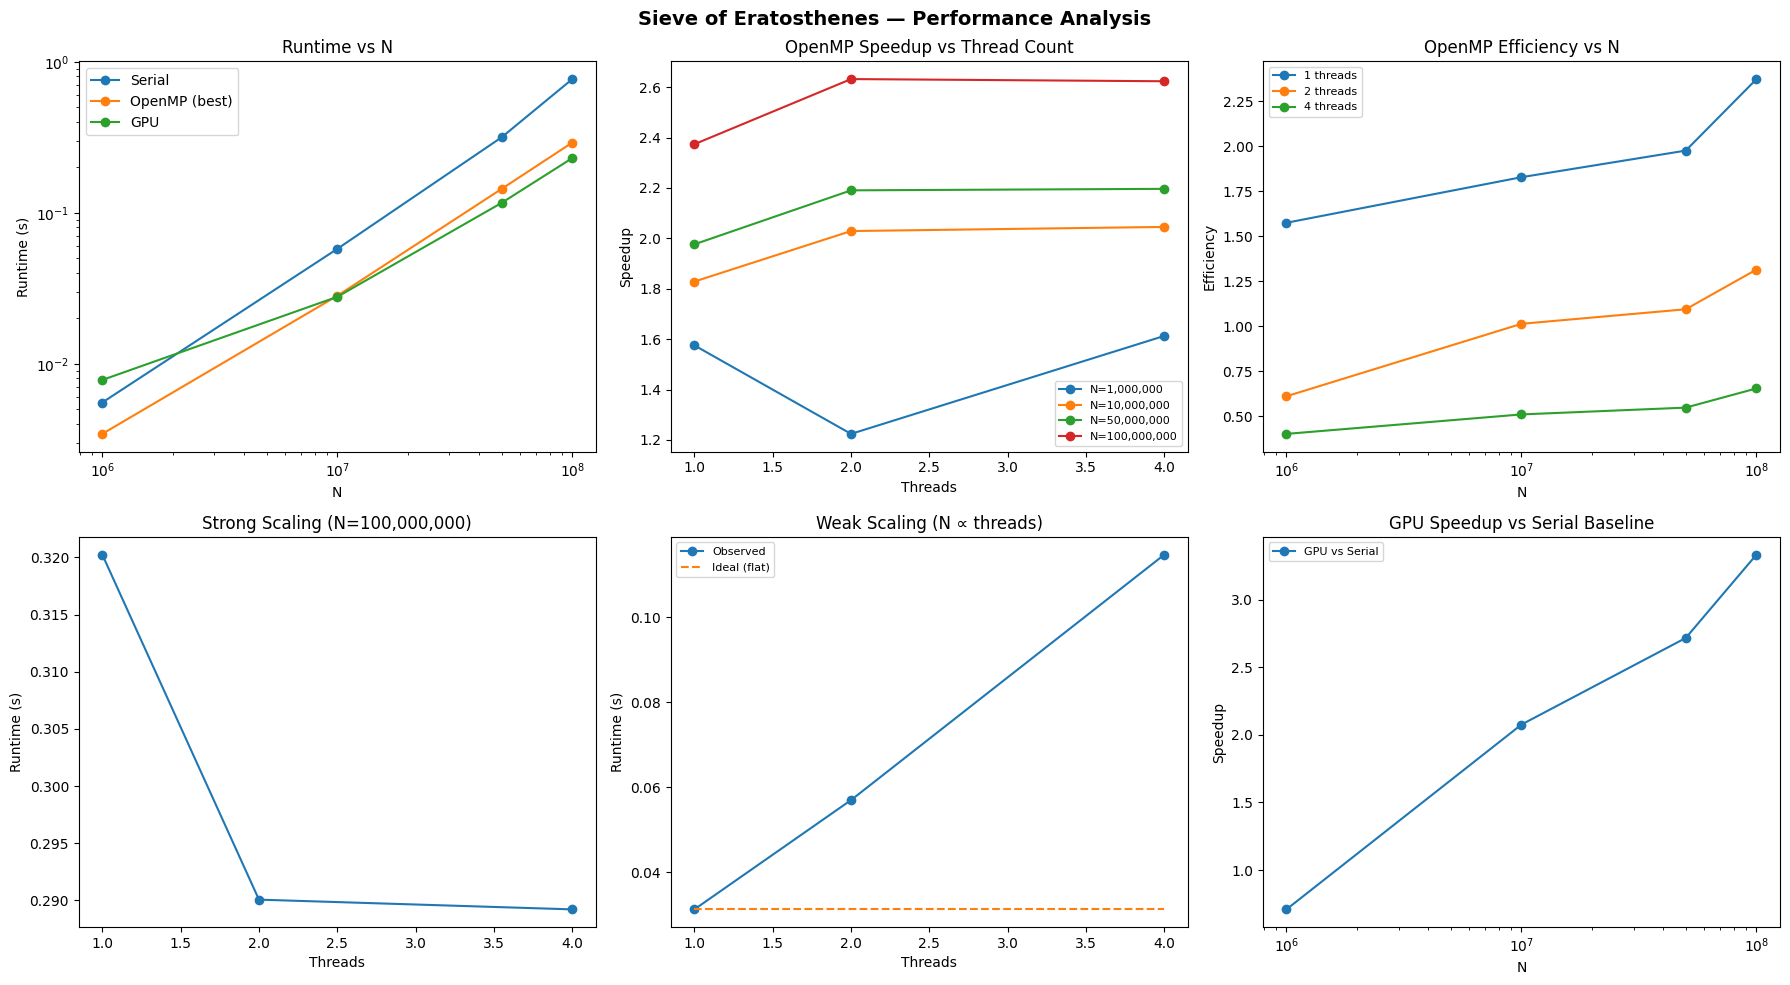

Saved performance_analysis.png


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If needed:
# results_df = pd.read_csv("results.csv")

# -----------------------------
# Basic sanity checks
# -----------------------------
if "results_df" not in globals():
    raise RuntimeError("results_df is not defined. Load your CSV first (e.g., pd.read_csv('results.csv')).")

if results_df.empty:
    raise RuntimeError("results_df is empty. No data available to plot.")

# Make a copy so we do not mutate original unexpectedly
results_df = results_df.copy()

# Normalize column names (strip spaces)
results_df.columns = [str(c).strip() for c in results_df.columns]

# Normalize implementation column naming
# Your pipeline seems to use 'impl', but some helper functions expect 'implementation'
if "impl" not in results_df.columns and "implementation" in results_df.columns:
    results_df["impl"] = results_df["implementation"]

if "implementation" not in results_df.columns and "impl" in results_df.columns:
    results_df["implementation"] = results_df["impl"]

# Normalize text values
for col in ["impl", "implementation"]:
    if col in results_df.columns:
        results_df[col] = results_df[col].astype(str).str.lower().str.strip()

# Convert numeric columns safely if present
for col in ["N", "threads", "trial", "time_sec", "count"]:
    if col in results_df.columns:
        results_df[col] = pd.to_numeric(results_df[col], errors="coerce")

# Optional: remove bad rows that would break plots
required_plot_cols = ["impl", "N", "time_sec"]
missing_required = [c for c in required_plot_cols if c not in results_df.columns]
if missing_required:
    raise RuntimeError(f"results_df is missing required columns for plotting: {missing_required}")

results_df = results_df.dropna(subset=["impl", "N", "time_sec"])

# -----------------------------
# Compute derived metrics safely
# -----------------------------
# Try user's function first; if it fails, build metrics manually.
try:
    metrics = compute_speedup_efficiency(results_df.copy())
except KeyError as e:
    print(f"compute_speedup_efficiency failed with KeyError: {e}")
    print("Falling back to manual metric computation using columns: impl, N, threads, time_sec")

    # Build metrics manually from results_df
    # Aggregate best time (min) per (impl, N, threads)
    agg = (
        results_df.groupby(["impl", "N", "threads"], as_index=False)["time_sec"]
        .min()
        .sort_values(["impl", "N", "threads"])
    )

    # Serial baseline per N (threads=1)
    serial_baseline = (
        agg[agg["impl"] == "serial"][["N", "time_sec"]]
        .rename(columns={"time_sec": "serial_time"})
    )

    metrics = agg.merge(serial_baseline, on="N", how="left")

    # Speedup = serial_time / current_time (primarily meaningful for OpenMP/GPU)
    metrics["speedup"] = np.where(
        (metrics["time_sec"] > 0) & metrics["serial_time"].notna(),
        metrics["serial_time"] / metrics["time_sec"],
        np.nan
    )

    # Efficiency = speedup / threads (primarily for OpenMP)
    metrics["efficiency"] = np.where(
        metrics["threads"] > 0,
        metrics["speedup"] / metrics["threads"],
        np.nan
    )

    # Keep compatibility if later code expects "implementation"
    metrics["implementation"] = metrics["impl"]

# Normalize metrics columns too
metrics.columns = [str(c).strip() for c in metrics.columns]
if "impl" not in metrics.columns and "implementation" in metrics.columns:
    metrics["impl"] = metrics["implementation"]
if "implementation" not in metrics.columns and "impl" in metrics.columns:
    metrics["implementation"] = metrics["impl"]

for col in ["impl", "implementation"]:
    if col in metrics.columns:
        metrics[col] = metrics[col].astype(str).str.lower().str.strip()

for col in ["N", "threads", "time_sec", "speedup", "efficiency"]:
    if col in metrics.columns:
        metrics[col] = pd.to_numeric(metrics[col], errors="coerce")

# -----------------------------
# Helper: inspect columns
# -----------------------------
print("results_df columns:", list(results_df.columns))
print("metrics columns:", list(metrics.columns))
print("\nresults_df head:")
display(results_df.head())
print("\nmetrics head:")
display(metrics.head())

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Sieve of Eratosthenes — Performance Analysis", fontsize=14, fontweight="bold")

# ── Plot 1: Runtime vs N ──────────────────────────────────────────────────────
ax = axes[0, 0]

if {"impl", "N", "time_sec"}.issubset(results_df.columns):
    # Serial
    serial_df = results_df[results_df["impl"] == "serial"].copy()
    if not serial_df.empty:
        serial_plot = serial_df.groupby("N", as_index=False)["time_sec"].min().sort_values("N")
        ax.plot(serial_plot["N"], serial_plot["time_sec"], marker="o", label="Serial")

    # OpenMP (best runtime across thread counts for each N)
    openmp_df = results_df[results_df["impl"] == "openmp"].copy()
    if not openmp_df.empty:
        openmp_best = openmp_df.groupby("N", as_index=False)["time_sec"].min().sort_values("N")
        ax.plot(openmp_best["N"], openmp_best["time_sec"], marker="o", label="OpenMP (best)")

    # GPU
    gpu_df = results_df[results_df["impl"] == "gpu"].copy()
    if not gpu_df.empty:
        gpu_plot = gpu_df.groupby("N", as_index=False)["time_sec"].min().sort_values("N")
        ax.plot(gpu_plot["N"], gpu_plot["time_sec"], marker="o", label="GPU")

ax.set_title("Runtime vs N")
ax.set_xlabel("N")
ax.set_ylabel("Runtime (s)")
ax.set_xscale("log")
ax.set_yscale("log")
if ax.has_data():
    ax.legend()

# ── Plot 2: Speedup vs Workers (OpenMP) ───────────────────────────────────────
ax = axes[0, 1]

if {"impl", "N", "threads", "speedup"}.issubset(metrics.columns):
    openmp_metrics = metrics[metrics["impl"] == "openmp"].copy()
    if not openmp_metrics.empty:
        for Nval in sorted(openmp_metrics["N"].dropna().unique()):
            sub = openmp_metrics[openmp_metrics["N"] == Nval].sort_values("threads")
            if not sub.empty:
                ax.plot(sub["threads"], sub["speedup"], marker="o", label=f"N={int(Nval):,}")

ax.set_title("OpenMP Speedup vs Thread Count")
ax.set_xlabel("Threads")
ax.set_ylabel("Speedup")
if ax.has_data():
    ax.legend(fontsize=8)

# ── Plot 3: Efficiency vs N ───────────────────────────────────────────────────
ax = axes[0, 2]

if {"impl", "N", "threads", "efficiency"}.issubset(metrics.columns):
    openmp_metrics = metrics[metrics["impl"] == "openmp"].copy()
    if not openmp_metrics.empty:
        for t in sorted(openmp_metrics["threads"].dropna().unique()):
            if pd.isna(t) or t == 0:
                continue
            sub = openmp_metrics[openmp_metrics["threads"] == t].sort_values("N")
            if not sub.empty:
                ax.plot(sub["N"], sub["efficiency"], marker="o", label=f"{int(t)} threads")

ax.set_title("OpenMP Efficiency vs N")
ax.set_xlabel("N")
ax.set_ylabel("Efficiency")
ax.set_xscale("log")
if ax.has_data():
    ax.legend(fontsize=8)

# ── Plot 4: Strong Scaling ────────────────────────────────────────────────────
ax = axes[1, 0]

target_N = 100_000_000
if {"impl", "N", "threads", "time_sec"}.issubset(results_df.columns):
    # Prefer dedicated strong-scaling rows if present
    strong_df = results_df[results_df["impl"].isin(["openmp_strong", "openmp"])].copy()

    if not strong_df.empty:
        strong = strong_df[strong_df["N"] == target_N].copy()

        if strong.empty and not strong_df["N"].dropna().empty:
            available_Ns = np.array(sorted(strong_df["N"].dropna().unique()))
            nearest_N = available_Ns[np.argmin(np.abs(available_Ns - target_N))]
            strong = strong_df[strong_df["N"] == nearest_N].copy()
            ax.set_title(f"Strong Scaling (N={int(nearest_N):,})")
        else:
            ax.set_title(f"Strong Scaling (N={target_N:,})")

        if not strong.empty:
            strong_best = strong.groupby("threads", as_index=False)["time_sec"].min().sort_values("threads")
            ax.plot(strong_best["threads"], strong_best["time_sec"], marker="o")
else:
    ax.set_title("Strong Scaling")

ax.set_xlabel("Threads")
ax.set_ylabel("Runtime (s)")

# ── Plot 5: Weak Scaling ──────────────────────────────────────────────────────
ax = axes[1, 1]

# Prefer dedicated weak rows if present
if {"impl", "N", "threads", "time_sec"}.issubset(results_df.columns):
    weak_source = results_df[results_df["impl"].isin(["openmp_weak", "openmp"])].copy()

    if not weak_source.empty:
        # If dedicated openmp_weak exists, use that directly
        weak_direct = weak_source[weak_source["impl"] == "openmp_weak"].copy()

        if not weak_direct.empty:
            weak_best = weak_direct.groupby("threads", as_index=False)["time_sec"].min().sort_values("threads")
            ax.plot(weak_best["threads"], weak_best["time_sec"], marker="o", label="Observed")
            if len(weak_best) > 0:
                ideal_time = weak_best["time_sec"].iloc[0]
                ax.plot(
                    weak_best["threads"],
                    [ideal_time] * len(weak_best),
                    linestyle="--",
                    label="Ideal (flat)"
                )
                ax.legend(fontsize=8)
        else:
            # Fallback heuristic from openmp rows
            openmp_df = weak_source[weak_source["impl"] == "openmp"].copy()
            available_threads = sorted(openmp_df["threads"].dropna().unique())
            if len(available_threads) > 0:
                base_thread = int(min(available_threads))
                base_candidates = openmp_df[openmp_df["threads"] == base_thread]["N"].dropna().unique()

                if len(base_candidates) > 0:
                    base_N = int(sorted(base_candidates)[0])
                    weak_rows = []
                    all_Ns = np.array(sorted(openmp_df["N"].dropna().unique()))

                    for t in available_threads:
                        t = int(t)
                        target = base_N * int(t / base_thread)
                        nearest_N = int(all_Ns[np.argmin(np.abs(all_Ns - target))])

                        sub = openmp_df[(openmp_df["threads"] == t) & (openmp_df["N"] == nearest_N)]
                        if not sub.empty:
                            best_row = sub.sort_values("time_sec").iloc[0]
                            weak_rows.append((t, nearest_N, float(best_row["time_sec"])))

                    if weak_rows:
                        weak_df = pd.DataFrame(weak_rows, columns=["threads", "N_used", "time_sec"])
                        ax.plot(weak_df["threads"], weak_df["time_sec"], marker="o", label="Observed")
                        ideal_time = weak_df["time_sec"].iloc[0]
                        ax.plot(
                            weak_df["threads"],
                            [ideal_time] * len(weak_df),
                            linestyle="--",
                            label="Ideal (flat)"
                        )
                        ax.legend(fontsize=8)

ax.set_title("Weak Scaling (N ∝ threads)")
ax.set_xlabel("Threads")
ax.set_ylabel("Runtime (s)")

# ── Plot 6: GPU Speedup vs Serial ────────────────────────────────────────────
ax = axes[1, 2]

if {"impl", "N", "time_sec"}.issubset(results_df.columns):
    serial_df = results_df[results_df["impl"] == "serial"].groupby("N", as_index=False)["time_sec"].min()
    gpu_df = results_df[results_df["impl"] == "gpu"].groupby("N", as_index=False)["time_sec"].min()

    if not serial_df.empty and not gpu_df.empty:
        merged = pd.merge(serial_df, gpu_df, on="N", suffixes=("_serial", "_gpu"))
        if not merged.empty:
            merged["gpu_speedup_vs_serial"] = merged["time_sec_serial"] / merged["time_sec_gpu"]
            merged = merged.sort_values("N")
            ax.plot(merged["N"], merged["gpu_speedup_vs_serial"], marker="o", label="GPU vs Serial")
            ax.legend(fontsize=8)

ax.set_title("GPU Speedup vs Serial Baseline")
ax.set_xlabel("N")
ax.set_ylabel("Speedup")
ax.set_xscale("log")

plt.tight_layout()
plt.savefig("performance_analysis.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved performance_analysis.png")

---
## 11. Part 3 — Real-World Extension: Cryptographic Primality (Option A)

Using the sieve output, identify primes with cryptographic significance:

- **Sophie Germain primes:** p such that both p and 2p+1 are prime
- **Safe primes:** q = 2p+1 where p is also prime (used in Diffie-Hellman, DSA)

**Why this matters:** Safe primes provide strong resistance against certain discrete logarithm attacks. Finding them efficiently over a bounded range is exactly what the sieve enables.

In [29]:
# ============================================================
# Cryptographic Primality and RSA Key Analysis Extension
# ============================================================

import math
import random
import time
from typing import List, Tuple, Dict, Optional


# ------------------------------------------------------------
# 1) CPU Sieve of Eratosthenes (exact primes in bounded range)
# ------------------------------------------------------------
def sieve_primes_upto(N: int, verbose: bool = False) -> List[int]:
    """
    Return all primes <= N using a standard CPU sieve.
    This is exact and suitable for bounded-range prime generation.
    """
    if verbose:
        print("\n[Phase A1] CPU Sieve of Eratosthenes")
        print(f"  Requested range: [2, {N:,}]")

    if N < 2:
        if verbose:
            print("  N < 2, so there are no primes to generate.")
        return []

    t0 = time.perf_counter()

    is_prime = bytearray(b"\x01") * (N + 1)
    is_prime[0:2] = b"\x00\x00"

    limit = int(math.isqrt(N))
    if verbose:
        print(f"  Sieve base loop upper bound = floor(sqrt(N)) = {limit:,}")

    for p in range(2, limit + 1):
        if is_prime[p]:
            start = p * p
            is_prime[start:N + 1:p] = b"\x00" * (((N - start) // p) + 1)

    primes = [i for i in range(2, N + 1) if is_prime[i]]

    if verbose:
        elapsed = time.perf_counter() - t0
        print("  Prime generation complete.")
        print(f"  Total primes found: {len(primes):,}")
        print(f"  Sieve execution time: {elapsed:.6f} seconds")
        print(f"  Sample (first 15 primes): {primes[:15]}")

    return primes


def build_sieve_prime_set(N: int, verbose: bool = False) -> Tuple[List[int], set]:
    """
    Generate both:
      - ordered prime list
      - hash set for O(1) membership testing
    """
    primes = sieve_primes_upto(N, verbose=verbose)
    return primes, set(primes)


# ------------------------------------------------------------
# 2) Cryptographically significant prime classes
# ------------------------------------------------------------
def find_sophie_germain_primes(prime_set: set, N: int) -> List[int]:
    """
    Sophie Germain primes:
      p is prime and (2p + 1) is also prime.
    This function only reports p values where 2p+1 <= N (same sieve range).
    """
    return sorted(
        [p for p in prime_set if (2 * p + 1) <= N and (2 * p + 1) in prime_set]
    )


def find_safe_primes(prime_set: set) -> List[int]:
    """
    Safe primes:
      q is prime and (q - 1) / 2 is also prime.
    """
    return sorted(
        [q for q in prime_set if ((q - 1) % 2 == 0) and (((q - 1) // 2) in prime_set)]
    )


# ------------------------------------------------------------
# 3) Miller-Rabin primality test (probabilistic)
# ------------------------------------------------------------
def _decompose_n_minus_one(n: int) -> Tuple[int, int]:
    """
    Write n - 1 = d * 2^s, where d is odd.
    Returns (s, d).
    """
    s = 0
    d = n - 1
    while d % 2 == 0:
        s += 1
        d //= 2
    return s, d


def is_probable_prime_miller_rabin(n: int, rounds: int = 16) -> bool:
    """
    Miller-Rabin primality test.
    - Exact for many practical small values due to pre-checks
    - Probabilistic for large integers (e.g., cryptographic-size candidates)
    """
    if n < 2:
        return False

    # Small-prime trial checks first (fast rejection)
    small_primes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37]
    for p in small_primes:
        if n == p:
            return True
        if n % p == 0:
            return False

    s, d = _decompose_n_minus_one(n)

    for _ in range(rounds):
        a = random.randrange(2, n - 1)
        x = pow(a, d, n)

        if x == 1 or x == n - 1:
            continue

        composite_witness = True
        for _ in range(s - 1):
            x = (x * x) % n
            if x == n - 1:
                composite_witness = False
                break

        if composite_witness:
            return False

    return True


# ------------------------------------------------------------
# 4) RSA modulus factorizability check using sieve-generated primes
# ------------------------------------------------------------
def rsa_small_factor_check_with_sieve(
    n: int,
    trial_bound: int = 1_000_000,
    verbose: bool = False
) -> Dict[str, Optional[int]]:
    """
    Attempt to detect a small prime factor of an RSA-like modulus n
    using trial division over sieve-generated primes <= trial_bound.

    Important:
      - This does NOT fully factor real 1024-bit RSA moduli in general.
      - It is a bounded small-factor check only.
    """
    if verbose:
        print("\n[Phase B1] RSA Small-Factor Check using Sieve + Trial Division")
        print(f"  Input modulus n: {n}")
        print(f"  Requested trial bound: {trial_bound:,}")

    if n < 2:
        return {
            "has_small_factor": False,
            "factor": None,
            "cofactor": None,
            "trial_bound": trial_bound,
            "effective_bound": 0,
            "primes_tested": 0,
            "elapsed_sec": 0.0,
        }

    t0 = time.perf_counter()

    effective_bound = min(trial_bound, int(math.isqrt(n)))
    if verbose:
        print(f"  Effective bound used = min(trial_bound, floor(sqrt(n))) = {effective_bound:,}")

    primes = sieve_primes_upto(effective_bound, verbose=False)

    if verbose:
        print(f"  Number of primes generated for trial division: {len(primes):,}")
        print("  Starting divisibility checks...")

    for idx, p in enumerate(primes, start=1):
        if n % p == 0:
            elapsed = time.perf_counter() - t0
            result = {
                "has_small_factor": True,
                "factor": p,
                "cofactor": n // p,
                "trial_bound": trial_bound,
                "effective_bound": effective_bound,
                "primes_tested": idx,  # actual checks performed
                "elapsed_sec": elapsed,
            }
            if verbose:
                print("  Small factor detected.")
                print(f"  Factor found: {p}")
                print(f"  Cofactor: {n // p}")
                print(f"  Divisibility checks performed: {idx:,}")
                print(f"  Execution time: {elapsed:.6f} seconds")
            return result

    elapsed = time.perf_counter() - t0
    result = {
        "has_small_factor": False,
        "factor": None,
        "cofactor": None,
        "trial_bound": trial_bound,
        "effective_bound": effective_bound,
        "primes_tested": len(primes),
        "elapsed_sec": elapsed,
    }

    if verbose:
        print("  No small factor detected within the specified bound.")
        print(f"  Divisibility checks performed: {len(primes):,}")
        print(f"  Execution time: {elapsed:.6f} seconds")

    return result


# ------------------------------------------------------------
# 5) Sieve-based small-factor check vs MR
#
# ------------------------------------------------------------
def compare_sieve_check_vs_miller_rabin(
    candidates: List[int],
    trial_bound: int = 1_000_000,
    mr_rounds: int = 16
) -> List[Dict[str, object]]:
    """
    For each candidate integer:
      1) run sieve-based small-factor check (bounded trial division)
      2) run Miller-Rabin primality test
    Returns structured results for report tables / reflection.
    """
    print("\n" + "=" * 78)
    print("Experiment C: Comparison of Sieve-Based Small-Factor Check vs Miller-Rabin")
    print("=" * 78)
    print("Purpose:")
    print("  Compare two different cryptographic screening strategies on integer candidates.")
    print("  - Sieve-based trial division: detects small factors (bounded, exact for tested primes)")
    print("  - Miller-Rabin: probable primality test (fast for large individual integers)")
    print(f"  Trial division bound = {trial_bound:,}")
    print(f"  Miller-Rabin rounds = {mr_rounds}")
    print()

    rows = []

    for i, n in enumerate(candidates, start=1):
        print(f"[Candidate {i}] n = {n}")

        t_sieve0 = time.perf_counter()
        sieve_result = rsa_small_factor_check_with_sieve(
            n, trial_bound=trial_bound, verbose=False
        )
        t_sieve = time.perf_counter() - t_sieve0

        t_mr0 = time.perf_counter()
        mr_result = is_probable_prime_miller_rabin(n, rounds=mr_rounds)
        t_mr = time.perf_counter() - t_mr0

        row = {
            "n": n,
            "sieve_has_small_factor": sieve_result["has_small_factor"],
            "sieve_factor": sieve_result["factor"],
            "sieve_primes_tested": sieve_result["primes_tested"],
            "sieve_time_sec": t_sieve,
            "miller_rabin_probable_prime": mr_result,
            "mr_time_sec": t_mr,
        }
        rows.append(row)

        print(f"  Sieve small-factor check: has_small_factor = {sieve_result['has_small_factor']}")
        if sieve_result["has_small_factor"]:
            print(f"    factor = {sieve_result['factor']}, cofactor = {sieve_result['cofactor']}")
        print(f"    time = {t_sieve:.6f} seconds")

        print(f"  Miller-Rabin probable prime result: {mr_result}")
        print(f"    time = {t_mr:.6f} seconds")
        print("-" * 78)

    print("Comparison experiment complete.")
    return rows


# ------------------------------------------------------------
# 6) SG primes + Safe primes from sieve output
# ------------------------------------------------------------
def run_crypto_extension(N: int, verbose: bool = True) -> Dict[str, object]:
    """
    Assignment core experiment:
      - generate primes using sieve
      - identify Sophie Germain primes
      - identify safe primes
    """
    if verbose:
        print("\n" + "=" * 78)
        print("Experiment A: Cryptographically Significant Primes from Sieve Output")
        print("=" * 78)
        print("Objective:")
        print("  Use an exact sieve over a bounded range to identify:")
        print("    1) Sophie Germain primes p such that 2p+1 is prime")
        print("    2) Safe primes q where (q-1)/2 is prime")
        print(f"  Search range: [2, {N:,}]")

    t0 = time.perf_counter()

    primes, prime_set = build_sieve_prime_set(N, verbose=verbose)
    sg_primes = find_sophie_germain_primes(prime_set, N)
    safe_primes = find_safe_primes(prime_set)

    elapsed = time.perf_counter() - t0

    if verbose:
        print("\n[Phase A2] Filtering sieve output for cryptographic prime classes")
        print(f"  Total primes <= N: {len(primes):,}")
        print(f"  Sophie Germain primes (p): {len(sg_primes):,}")
        print(f"  Safe primes (q):           {len(safe_primes):,}")
        print(f"  End-to-end time (sieve + filtering): {elapsed:.6f} seconds")

        print("\nSample outputs (first 10 values)")
        print(f"  Sophie Germain primes p: {sg_primes[:10]}")
        print(f"  Safe primes q:           {safe_primes[:10]}")

        print("\nSample pair mapping (p, q = 2p+1)")
        for p in sg_primes[:10]:
            q = 2 * p + 1
            print(f"  p = {p:<8}  q = {q}")

        print("=" * 78)

    return {
        "N": N,
        "primes": primes,
        "prime_set": prime_set,
        "sophie_germain_primes": sg_primes,
        "safe_primes": safe_primes,
        "elapsed_sec": elapsed,
    }


# ------------------------------------------------------------
# 7) RSA factorizability demonstration
# ------------------------------------------------------------
def run_rsa_factorizability_demo() -> None:
    """
    Demonstrate bounded small-factor detection and contrast it with MR.
    """
    print("\n" + "=" * 78)
    print("Experiment B: RSA-Modulus Factorizability Checking (Bounded Small-Factor Test)")
    print("=" * 78)
    print("Objective:")
    print("  Check whether a candidate RSA-like modulus has a small prime factor")
    print("  using sieve-generated primes for trial division.")
    print()

    # Case B1: toy RSA modulus (known factorable quickly)
    n1 = 61 * 53  # 3233
    print("[Case B1] Toy RSA modulus")
    print(f"  n1 = 61 * 53 = {n1}")
    result1 = rsa_small_factor_check_with_sieve(n1, trial_bound=1000, verbose=True)
    print("  Structured result:", result1)
    print()

    # Case B2: larger semiprime-like modulus
    p2 = 1_000_003
    q2 = 1_000_033
    n2 = p2 * q2
    print("[Case B2] Larger semiprime-like modulus")
    print(f"  n2 = {p2} * {q2} = {n2}")
    result2 = rsa_small_factor_check_with_sieve(n2, trial_bound=200_000, verbose=True)
    print("  Structured result:", result2)
    print()

    # Case B3: MR illustration on factors and modulus
    print("[Case B3] Miller-Rabin primality test (illustrative)")
    print(f"  MR({p2}) = {is_probable_prime_miller_rabin(p2)}")
    print(f"  MR({q2}) = {is_probable_prime_miller_rabin(q2)}")
    print(f"  MR({n2}) = {is_probable_prime_miller_rabin(n2)}")

    print("=" * 78)


# ------------------------------------------------------------
# 8) Bounded-region scan using prefilter + MR
#    This is a practical stand-in for "1024-bit region" workflow style.
# ------------------------------------------------------------
def scan_region_with_small_prime_prefilter_and_mr(
    start: int,
    count_odds: int,
    small_prime_bound: int = 10_000,
    mr_rounds: int = 16,
    verbose: bool = False,
) -> Dict[str, object]:
    """
    Scan odd candidates in a bounded region:
      1) reject via small-prime divisibility (sieve-generated primes)
      2) apply Miller-Rabin to survivors
    """
    if start % 2 == 0:
        start += 1

    if verbose:
        print("\n[Phase D1] Bounded Region Candidate Scan")
        print(f"  Starting odd candidate: {start}")
        print(f"  Odd candidates to test: {count_odds:,}")
        print(f"  Small-prime prefilter bound: {small_prime_bound:,}")
        print(f"  Miller-Rabin rounds: {mr_rounds}")

    t0 = time.perf_counter()

    small_primes = sieve_primes_upto(small_prime_bound, verbose=False)
    small_primes = [p for p in small_primes if p != 2]

    total_candidates = 0
    prefilter_survivors = 0
    probable_primes = []

    for i in range(count_odds):
        x = start + 2 * i
        total_candidates += 1

        divisible = False
        for p in small_primes:
            if p * p > x:
                break
            if x % p == 0:
                divisible = True
                break

        if divisible:
            continue

        prefilter_survivors += 1

        if is_probable_prime_miller_rabin(x, rounds=mr_rounds):
            probable_primes.append(x)

    elapsed = time.perf_counter() - t0

    stats = {
        "start": start,
        "count_odds": count_odds,
        "small_prime_bound": small_prime_bound,
        "mr_rounds": mr_rounds,
        "total_candidates": total_candidates,
        "prefilter_survivors": prefilter_survivors,
        "probable_primes_found": len(probable_primes),
        "first_probable_primes": probable_primes[:10],
        "elapsed_sec": elapsed,
    }

    if verbose:
        print("  Scan complete.")
        print(f"  Total odd candidates evaluated: {total_candidates:,}")
        print(f"  Survivors after small-prime prefilter: {prefilter_survivors:,}")
        print(f"  Probable primes (MR): {len(probable_primes):,}")
        print(f"  Sample probable primes: {probable_primes[:10]}")
        print(f"  Execution time: {elapsed:.6f} seconds")

    return stats


def run_optional_region_scan_demo() -> None:
    """
    Optional experiment for report enrichment.
    """
    print("\n" + "=" * 78)
    print("Experiment D (Optional): Bounded Candidate Scan with Prefilter + Miller-Rabin")
    print("=" * 78)
    print("Objective:")
    print("  Demonstrate a practical crypto-style candidate filtering pipeline using")
    print("  sieve-generated small primes followed by Miller-Rabin on survivors.")
    print()

    stats = scan_region_with_small_prime_prefilter_and_mr(
        start=10**6 + 1,
        count_odds=5000,
        small_prime_bound=5000,
        mr_rounds=12,
        verbose=True
    )

    print("\nStructured summary for reporting:")
    for k, v in stats.items():
        print(f"  {k}: {v}")

    print("=" * 78)



def generate_sg_safe_count_table(N_values: List[int], verbose: bool = False) -> List[Dict[str, object]]:
    """
    Generate table rows for:
      - total primes pi(N)
      - Sophie Germain prime count
      - safe prime count
      - SG density (% of total primes)
    """
    print("\n" + "=" * 78)
    print("Table 7 Generation: Sophie Germain and Safe Prime Counts by N")
    print("=" * 78)

    rows = []

    for N in N_values:
        print(f"\nProcessing N = {N:,} ...")
        result = run_crypto_extension(N=N, verbose=verbose)

        total_primes = len(result["primes"])
        sg_count = len(result["sophie_germain_primes"])
        safe_count = len(result["safe_primes"])

        sg_density_pct = (sg_count / total_primes * 100.0) if total_primes > 0 else 0.0

        row = {
            "N": N,
            "Total primes π(N)": total_primes,
            "Sophie Germain": sg_count,
            "Safe primes": safe_count,
            "SG density (%)": sg_density_pct,
            "Elapsed time (s)": result["elapsed_sec"],
        }
        rows.append(row)

        print(f"  Total primes π(N):   {total_primes:,}")
        print(f"  Sophie Germain:      {sg_count:,}")
        print(f"  Safe primes:         {safe_count:,}")
        print(f"  SG density (%):      {sg_density_pct:.2f}")
        print(f"  Elapsed time (s):    {result['elapsed_sec']:.6f}")

    print("\n" + "-" * 78)
    print("Table 7 (formatted summary)")
    print("-" * 78)
    print(f"{'N':>12} {'Total primes π(N)':>20} {'Sophie Germain':>18} {'Safe primes':>14} {'SG density (%)':>15}")
    for r in rows:
        print(
            f"{r['N']:>12,} "
            f"{r['Total primes π(N)']:>20,} "
            f"{r['Sophie Germain']:>18,} "
            f"{r['Safe primes']:>14,} "
            f"{r['SG density (%)']:>15.2f}"
        )

    return rows


# ------------------------------------------------------------
# 9) Main execution
# ------------------------------------------------------------
if __name__ == "__main__":
    print("\n" + "#" * 78)
    print("Cryptographic Primality and RSA Key Analysis — Assignment Execution")
    print("#" * 78)

    # Reproducibility for Miller-Rabin random bases
    random.seed(42)
    print("Random seed set to 42 for reproducible Miller-Rabin base selection.")

    # Experiment A: SG primes + safe primes (required)
    crypto_data = run_crypto_extension(N=10**6, verbose=True)

    # Experiment B: RSA modulus small-factor checking (required)
    run_rsa_factorizability_demo()

    # Experiment C: Sieve small-factor check vs Miller-Rabin comparison (required-style comparison)
    comparison_candidates = [
        3233,                       # toy RSA modulus = 61*53 (composite)
        1000003,                    # prime
        1000033,                    # prime (example candidate)
        1000003 * 1000033,          # semiprime-like composite
        (10**12 + 39),              # random large-ish candidate
    ]
    comparison_rows = compare_sieve_check_vs_miller_rabin(
        comparison_candidates,
        trial_bound=200_000,
        mr_rounds=12
    )

    print("\nStructured comparison rows (for report tables):")
    for row in comparison_rows:
        print(" ", row)

    # Table 7: SG and safe prime counts by N (required notebook section results)
    table7_N_values = [10**4, 10**5, 10**6, 10**7]
    table7_rows = generate_sg_safe_count_table(table7_N_values, verbose=False)

        # Optional: save table rows to CSV for notebook/report formatting
    try:
        import pandas as pd
        df_table7 = pd.DataFrame(table7_rows)
        df_table7.to_csv("table7_sg_safe_counts.csv", index=False)
        print("\nSaved Table 7 results to table7_sg_safe_counts.csv")
    except ImportError:
        print("\nPandas not available; skipping CSV export for Table 7.")

    print("\nExecution completed successfully.")


##############################################################################
Cryptographic Primality and RSA Key Analysis — Assignment Execution
##############################################################################
Random seed set to 42 for reproducible Miller-Rabin base selection.

Experiment A: Cryptographically Significant Primes from Sieve Output
Objective:
  Use an exact sieve over a bounded range to identify:
    1) Sophie Germain primes p such that 2p+1 is prime
    2) Safe primes q where (q-1)/2 is prime
  Search range: [2, 1,000,000]

[Phase A1] CPU Sieve of Eratosthenes
  Requested range: [2, 1,000,000]
  Sieve base loop upper bound = floor(sqrt(N)) = 1,000
  Prime generation complete.
  Total primes found: 78,498
  Sieve execution time: 0.088728 seconds
  Sample (first 15 primes): [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47]

[Phase A2] Filtering sieve output for cryptographic prime classes
  Total primes <= N: 78,498
  Sophie Germain primes (p): 4,32

---
## 13. Export Artifacts

Save all outputs needed for submission.

In [30]:
import os

# Save results CSV
results_df.to_csv("results.csv", index=False)
print("Saved: results.csv")

# Save plots (call savefig in section 10 cells above)
# performance_analysis.png is already saved

# List generated files
artifacts = ["results.csv", "performance_analysis.png",
             "sieve_serial.cpp", "sieve_openmp.cpp",
             "sieve_serial", "sieve_openmp"]
for f in artifacts:
    status = "OK" if os.path.exists(f) else "MISSING"
    print(f"  [{status}] {f}")


Saved: results.csv
  [OK] results.csv
  [OK] performance_analysis.png
  [OK] sieve_serial.cpp
  [OK] sieve_openmp.cpp
  [OK] sieve_serial
  [OK] sieve_openmp
